# Preparatory Work and Data Analysis

### 1) 

Answered in the report

### 2)

In [1]:
import numpy as np
import random

mu_1 = np.array([-3, 0])
mu_2 = np.array([3, 0])
sigma_1 = np.array([[5, -2], [-2, 1]])
sigma_2 = np.array([[5, 2], [2, 2]])

X = []
Y = []

# generate data of the desired distribution
for i in range(0,500):
    r = random.uniform(0, 1)
    if r < 0.3:
        x, y = np.random.multivariate_normal(mu_1, sigma_1)
    else:
        x, y = np.random.multivariate_normal(mu_2, sigma_2)
    X.append(x)
    Y.append(y)


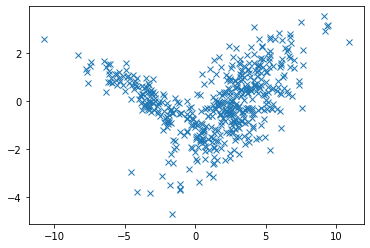

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(X, Y, 'x')
plt.show()

### 3)

For the following the Unistroke data set must be in the same directory as this notebook

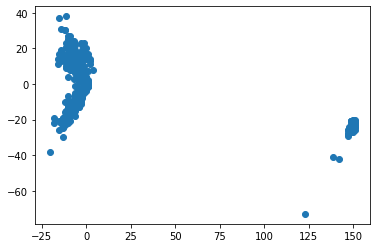

In [3]:
# reading the data and calculating the difference immediately

import pandas as pd

data = pd.read_csv('Unistroke/A01.txt', sep="\t", header=None).diff().iloc[1:]

for i in range(2,10):
    data = pd.concat([data, pd.read_csv('Unistroke/A0' + str(i) + '.txt', sep="\t", header=None).diff().iloc[1:]], ignore_index=True)
for i in range(10,51):
    data = pd.concat([data, pd.read_csv('Unistroke/A' + str(i) + '.txt', sep="\t", header=None).diff().iloc[1:]], ignore_index=True)

data.columns = ['x', 'y']
plt.scatter(data.x, data.y)

In [4]:
data2 = data.to_numpy()

In [5]:
data

,x,y
0,150.0,-21.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
958,-4.0,7.0
959,-2.0,3.0
960,1.0,-1.0
961,0.0,0.0


In [6]:
for i in range(len(data2)):
    x = data2[i][0]
    y = data2[i][1]
    if x != 0 or y != 0:
        mag = np.sqrt(x**2 + y**2)
        data2[i][0] = x / mag
        data2[i][1] = y / mag


# removing vector zero
data2 = data2[~np.all(data2 == 0, axis=1)]

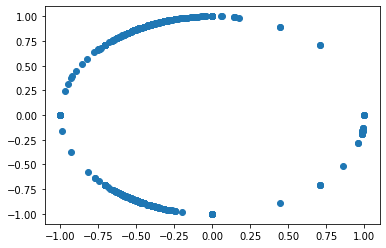

In [7]:
# plotting the normalized vectors

plt.scatter(data2[:,0], data2[:,1])

In [8]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=2, n_init=10, random_state=0)

In [9]:
# fitting a two component GMM

y = model.fit_predict(data2)

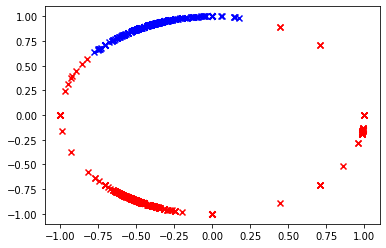

In [10]:
# splitting the data into different subgroups depending on the predicted class.
# Here the code works whether n_components = 2 or 3

x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []

for i in range(len(data2)):
    if y[i] == 0:
        x1.append(data2[i][0])
        y1.append(data2[i][1])
    elif y[i] == 1:
        x2.append(data2[i][0])
        y2.append(data2[i][1])
    else:
        x3.append(data2[i][0])
        y3.append(data2[i][1])
        
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x1, y1, c='b', marker="x")
ax1.scatter(x2, y2, c='r', marker="x")
ax1.scatter(x3, y3, c='k', marker="x")


plt.show()

### 2)

/Users/david.emukpere/miniconda3/envs/pytorch-challenge/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Log scale: values of z <= 0 have been masked
/Users/david.emukpere/miniconda3/envs/pytorch-challenge/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


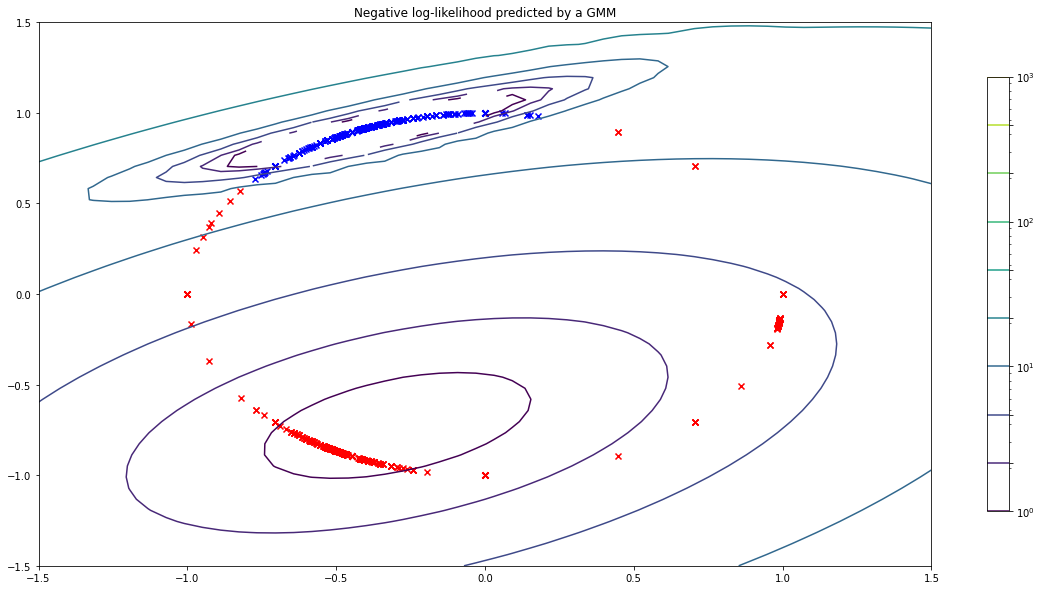

In [11]:
# plotting the contours of the log likelihood of the gmm
# inspired from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html

from matplotlib.colors import LogNorm
X_train = data2
clf = model

# display predicted scores by the model as a contour plot
x = np.linspace(-1.5, 1.5)
y = np.linspace(-1.5, 1.5)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

fig, ax = plt.subplots(figsize=(20, 10))

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
ax.scatter(x1, y1, c='b', marker="x")
ax.scatter(x2, y2, c='r', marker="x")
ax.scatter(x3, y3, c='k', marker="x")
plt.title('Negative log-likelihood predicted by a GMM')
ax.axis('tight')
fig.show()

### 3)

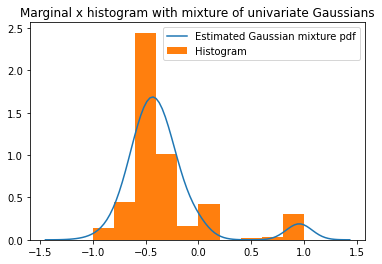

In [12]:
import seaborn as sns

all_x = []
all_y = []

for x_i , y_i in data2:
    all_x.append(x_i)
    all_y.append(y_i)

# fitting a univariate gmm on x-coordinates only
model_x = GaussianMixture(n_components=2, n_init=10, random_state=0)
model_x_pred = model_x.fit_predict(np.array(all_x).reshape(-1,1))
# extracting the parameters
weights_x = model_x.weights_.reshape(-1,)
mu_x = model_x.means_.reshape(-1,)
sigma_x = model_x.covariances_.reshape(-1,)
sdevs_x = np.sqrt(sigma_x)

samples_x = []
# generating random data according to the distribution to plot it
for i in range(0, 1000):
    if random.uniform(0, 1) < weights_x[0]:
        z = 0
    else:
        z = 1
    samples_x.append(np.random.normal(mu_x[z], sdevs_x[z], 1))

# plot the predicted distribution curve along with the histogram of the x-coordinates
sns.distplot(samples_x, hist=False, label='Estimated Gaussian mixture pdf')

plt.hist(all_x, density=True, label='Histogram')
plt.title('Marginal x histogram with mixture of univariate Gaussians')
plt.legend()

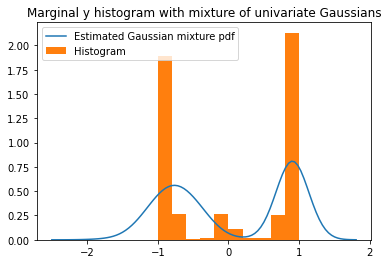

In [13]:
# SAME BUT FOR Y-COORDINATES

model_y = GaussianMixture(n_components=2, n_init=10, random_state=0)
model_y_pred = model_y.fit_predict(np.array(all_y).reshape(-1,1))

weights_y = model_y.weights_.reshape(-1,)
mu_y = model_y.means_.reshape(-1,)
sigma_y = model_y.covariances_.reshape(-1,)
sdevs_y = np.sqrt(sigma_y)

samples_y = []
for i in range(0, 1000):
    if random.uniform(0, 1) < weights_y[0]:
        z = 0
    else:
        z = 1
    samples_y.append(np.random.normal(mu_y[z], sdevs_y[z], 1))

sns.distplot(samples_y, hist=False, label='Estimated Gaussian mixture pdf')

plt.hist(all_y, density=True, label='Histogram')
plt.title('Marginal y histogram with mixture of univariate Gaussians')
plt.legend()


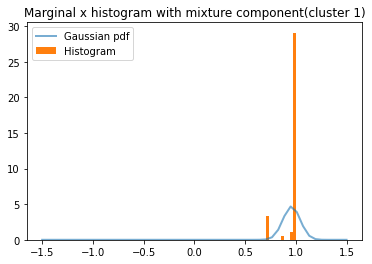

In [14]:
# plotting the histogram of x-coordinates of the FIRST CLASS against the univariate distr
from scipy.stats import norm

plt.plot(x, norm.pdf(x, loc=mu_x[0], scale=sdevs_x[0]), lw=2, alpha=0.6, label='Gaussian pdf')
plt.hist(np.array(all_x)[model_x_pred == 0], density=True, label='Histogram')
plt.title('Marginal x histogram with mixture component(cluster 1)')
plt.legend()

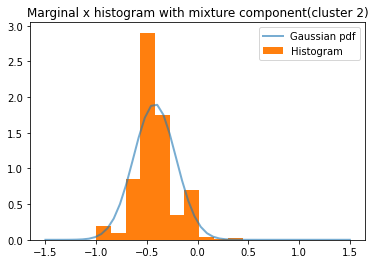

In [15]:
# plotting the x coordinates of the SECOND CLASS against the univariate distr

plt.plot(x, norm.pdf(x, loc=mu_x[1], scale=sdevs_x[1]), lw=2, alpha=0.6, label='Gaussian pdf')
plt.hist(np.array(all_x)[model_x_pred == 1], density=True, label='Histogram')
plt.title('Marginal x histogram with mixture component(cluster 2)')
plt.legend()

1.2964913174273995
-0.7393449894180377 0.30770918018413385


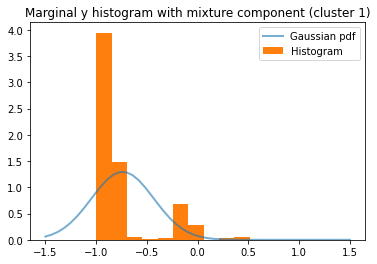

In [16]:
# plotting the Y-COORDINATES of the FIRST CLASS against the univariate distr

# sns.distplot(samples_y, hist=False)
plt.plot(y, norm.pdf(y, loc=mu_y[0], scale=sdevs_y[0]), lw=2, alpha=0.6, label='Gaussian pdf')
plt.hist(np.array(all_y)[model_y_pred == 0], density=True, label='Histogram')
plt.title('Marginal y histogram with mixture component (cluster 1)')
plt.legend()
print(1 / (np.sqrt(2 * np.pi) * sdevs_y[0]))
print(mu_y[0], sdevs_y[0])

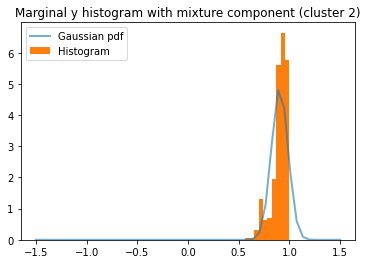

In [17]:
# plotting the Y-COORDINATES of the SECOND CLASS against the univariate distr
plt.plot(y, norm.pdf(y, loc=mu_y[1], scale=sdevs_y[1]), lw=2, alpha=0.6, label='Gaussian pdf')
plt.hist(np.array(all_y)[model_y_pred == 1], density=True, label='Histogram')
plt.title('Marginal y histogram with mixture component (cluster 2)')
plt.legend()

### 4)

Using a bivariate GMM is valid, as the univariate ones fail to capture the "natural" clustering of the data. In both univariate GMMs we can see that one component typically dominates, being assigned most of the data points. This is expected because when we consider marginals in X or Y, we effectively reduce the dimensionality of the data. As such, it becomes  difficult to separate the data into clusters that are apparent in the original higher dimensions. In our dataset, directions are important for clustering and we lose this information if we consider only univariate mixtures.

###  5)

References:
- [https://matplotlib.org/tutorials/colors/colormap-manipulation.html](https://matplotlib.org/tutorials/colors/colormap-manipulation.html)
- [https://matplotlib.org/tutorials/colors/colormaps.html](https://matplotlib.org/tutorials/colors/colormaps.html)

Text(0.5, 1.0, 'Data labeled with colourmap for component responsibilities')

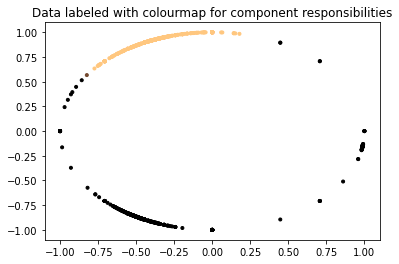

In [18]:
from matplotlib import cm

# get posterior probabilities to be used as input to color_map functions
P_Z = model.predict_proba(data2) 
color_map = cm.get_cmap('copper')
colors = [color_map(x) for x in P_Z[:, 0]]

plt.scatter(data2[:,0], data2[:,1], c=colors, marker='.')
plt.title('Data labeled with colourmap for component responsibilities')

The plot can be interpreted as showing how much mixing of the two Guasssian components occurs for each data point. For the color map we've defined, the black colored points correspond to points where the first component takes a very high responsibility while the light brown colored points correspond to those for the second component. We can observe a brown data point which indicates that the two components do not have as high responsibilities in this case. Said differently, the data point is generated by a stronger mix of the two mixture components than as seen with other points.

# Mandatory Work
### 1)

Text(0.5, 0, 'Angles (radians)')

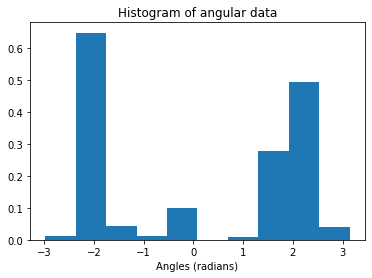

In [19]:
# calculating the angles and plotting their histogram

angles = np.arctan2(data2[:,1], data2[:,0])
plt.hist(angles, density=True)
plt.title('Histogram of angular data')
plt.xlabel('Angles (radians)')

### 2), 3), 4)

Answered in the accompanying report

### 5)

### Fitting a mixture of von Mises distributions

References:
- [Clustering on the Unit Hypersphere using von Mises-Fisher Distributions](https://www.jmlr.org/papers/volume6/banerjee05a/banerjee05a.pdf)
- [spherecluster](https://github.com/jasonlaska/spherecluster)

Code in the following sections depends on the library: [spherecluster](https://github.com/jasonlaska/spherecluster)

Installation can be done in two ways as described in the linked repo. If you choose to install from PyPI by `pip install spherecluster`, you might run into an error `ImportError: cannot import name '_k_means' from 'sklearn.cluster'`. To fix this, you have to downgrade your scikit-learn to version 0.22.0 e.g. by running `conda install scikit-learn=0.22.0`.

However, cloning the repository and installing with the develop branch fixes this issue. For more details, see this closed issue [ImportError: cannot import name '\_k\_means' #26](https://github.com/jasonlaska/spherecluster/issues/26)



In [20]:
from spherecluster import VonMisesFisherMixture

movm = VonMisesFisherMixture(n_clusters=2, posterior_type='soft', random_state=0)
movm.fit(data2) # note the library expects data in the form of normalized vectors, not angles

print('Estimated parameters',
      '===========================================================',
      f'Means/Positions[vectors]: {movm.cluster_centers_}',
      f'Means/Positions[angles]: {np.arctan2(movm.cluster_centers_[:, 1], movm.cluster_centers_[:, 0])}',
      f'Concentrations: {movm.concentrations_}',
      f'Weights: {movm.weights_}',
      sep='\n')


/Users/david.emukpere/miniconda3/envs/pytorch-challenge/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Estimated parameters
Means/Positions[vectors]: [[-0.37332574  0.92770032]
 [-0.38273353 -0.92385878]]
Means/Positions[angles]: [ 1.9533877  -1.96354963]
Concentrations: [22.05927702  2.71229065]
Weights: [0.47066647 0.52933353]


Text(0.5, 1.0, 'Data labeled according to mixture of von-Mises distributions')

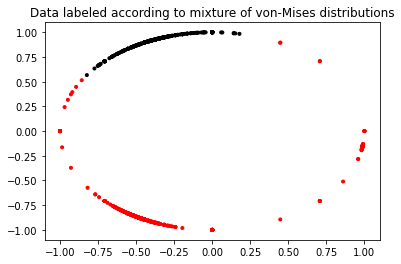

In [21]:
colors = ['r' if label == 1 else 'k' for label in movm.labels_]

plt.scatter(data2[:,0], data2[:,1], c=colors, marker='.')
plt.title('Data labeled according to mixture of von-Mises distributions')